# Purpose of Notebook

The goal of this code is to investigate deep mixing with Red Giants.
- The mass used will be generated using a Random Forest Model

The steps that will need to be taken in order to investigate deep mixing
1.  Compute Carbon to Nitrogen Ratio for Red Giants $$ \Big[\frac{C}{N}\Big] = \Big[\frac{C}{Fe}\Big] - \Big[\frac{N}{Fe}\Big] $$
2.  Determine which stars are Red Giants
    - To achieve this, we will need to graph `log(g)` vs `teff` to create a HR diagram
    - Using the HR diagram, we will then determine the Red Giants

3.  Separate Stars into bins and compute their change in carbon/nitrogen over `log g`

## Expected Results
We should see the deep mixing decreases as a function of mass and metallicity.
- Which of the two factors are more significant remains to be seen.

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.linear_model import LinearRegression
from statistics import mean

In [134]:
apogee = pd.read_csv("ProcessedData/apogee_with_mass.csv")

# 1. Compute Relative Abundance of Carbon to Nitrogen

In [18]:
apogee["c_n"] = apogee.c_fe - apogee.n_fe
apogee.columns

Index(['tmass_id', 'teff', 'logg', 'fe_h', 'alpha_m', 'c_fe', 'n_fe', 'o_fe',
       'ra', 'dec', 'vhelio_avg', 'gaiaedr3_pmra', 'gaiaedr3_pmdec', 'mass',
       'c_n'],
      dtype='object')

In [19]:
apogee.c_n

0        -0.141925
1        -0.766240
2        -0.109907
3        -0.312257
4        -0.526230
            ...   
419051   -0.057909
419052   -0.188439
419053   -0.344606
419054   -0.262194
419055   -0.220958
Name: c_n, Length: 419056, dtype: float64

# 2. Find the !(Blue Midgets)

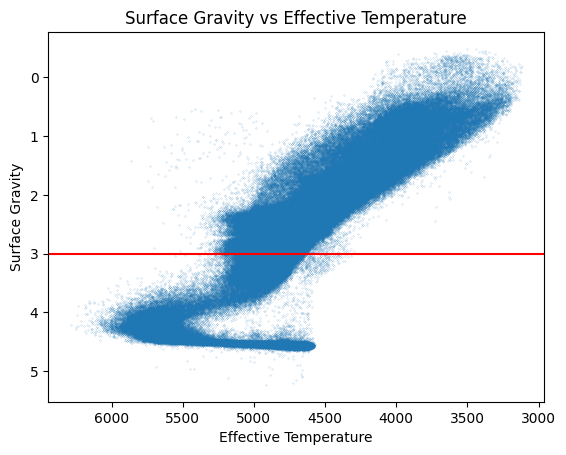

In [20]:
figure = plt.plot(
    apogee.teff,
    apogee.logg,
    '.',
    markersize=0.2,
)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Effective Temperature")
plt.ylabel("Surface Gravity")
plt.title("Surface Gravity vs Effective Temperature")
# The Cutoff is round
plt.axhline(y=3, color='r', linestyle='-')

Text(0.5, 1.0, 'Surface Gravity vs Log Effective Temperature')

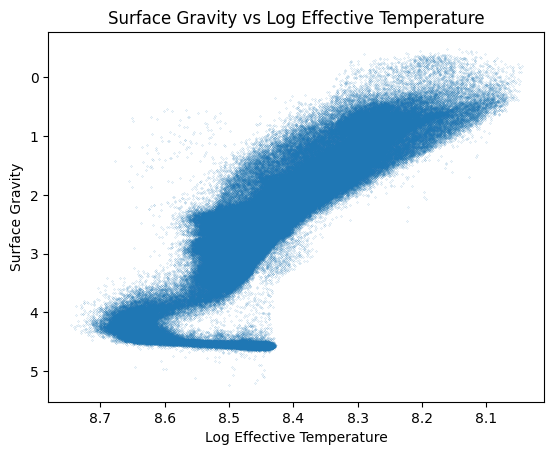

In [21]:
plt.plot(
    np.log(apogee.teff),
    apogee.logg,
    '.',
    markersize=0.2,
)
plt.plot()

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Log Effective Temperature")
plt.ylabel("Surface Gravity")
plt.title("Surface Gravity vs Log Effective Temperature")
# No significant difference so this will be ignored.

Based on the analysis above, the ideal cutoff for red giants is for `log g > 3.5`.

In [22]:
red_giants_apogee = apogee.query("logg < 3")
red_giants_apogee.to_csv("ProcessedData/apogee_red_giant.csv", index=False)

In [135]:
red_giants_apogee = pd.read_csv("ProcessedData/apogee_red_giant.csv")

# 3. Investigate Deep Mixing as a function of Mass and Metallicity.


Separate Data into 25 Groups, which is determined by the metallicity and mass.
- Separate Mass like so:
$$ 0.5 \leq \frac{M}{M_\odot} < 1 , 1 \leq \frac{M}{M_\odot} < 1.25,  1.25 \leq \frac{M}{M_\odot} < 1.50, 1.50 \leq \frac{M}{M_\odot} < 2.2 ,\frac{M}{M_\odot} \geq 2.2 $$

- Separate Metallicity like so:
$$ 0.25 \geq \Big[\frac{Fe}{H}\Big] > -0.25$, -0.25 \geq \Big[\frac{Fe}{H}\Big] > -0.75$, -0.75 \geq \Big[\frac{Fe}{H}\Big] > -1.25$, -1.25 \geq \Big[\frac{Fe}{H}\Big] > -1.75$, -1.75 \geq \Big[\frac{Fe}{H}\Big] > -4 $$


In [24]:
fe_h_range = [0.25, -0.25, -0.75, -1.25, -1.75, -4]
mass_range = [0.5, 1, 1.25, 1.5, 2.2, 4.0]
# Approximate position of RGBb
rgbbedge = [[2.666, 2.661, 2.654, 2.587, 2.50],
            [2.509, 2.500, 2.432, 2.456, 2.4],
            [2.301, 2.277, 2.222, 2.186, 2.1],
            [2.106, 2.060, 2.036, 2.098, 2.0],
            [1.953, 1.895, 1.881, 1.846, 1.8]]

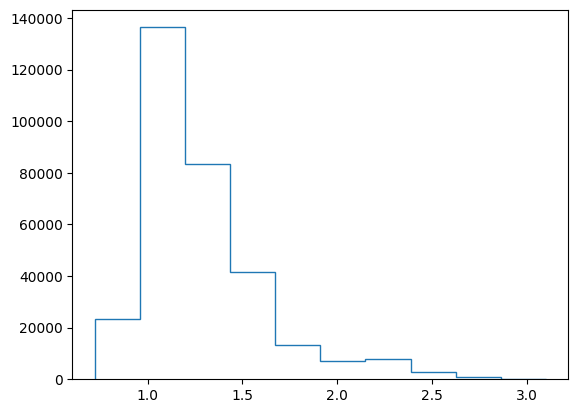

In [25]:
red_giants_apogee.mass.describe()
counts, bins = np.histogram(red_giants_apogee.mass)
plt.stairs(counts, bins)

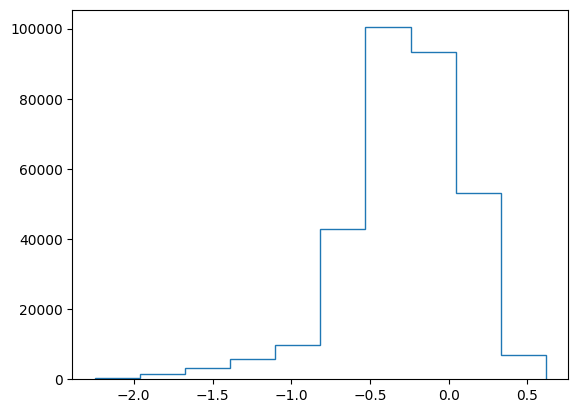

In [26]:
red_giants_apogee.fe_h.describe()
counts, bins = np.histogram(red_giants_apogee.fe_h)
plt.stairs(counts, bins)

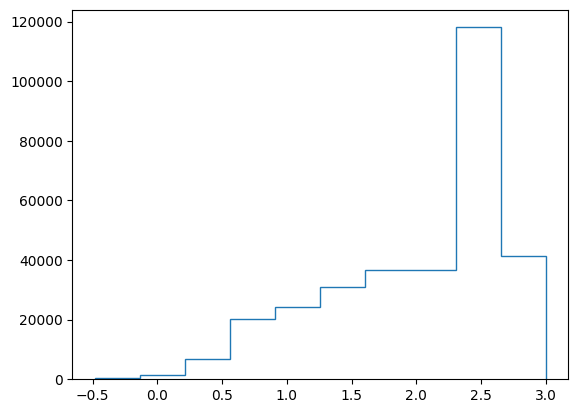

In [27]:
red_giants_apogee.logg.describe()
counts, bins = np.histogram(red_giants_apogee.logg)
plt.stairs(counts, bins)

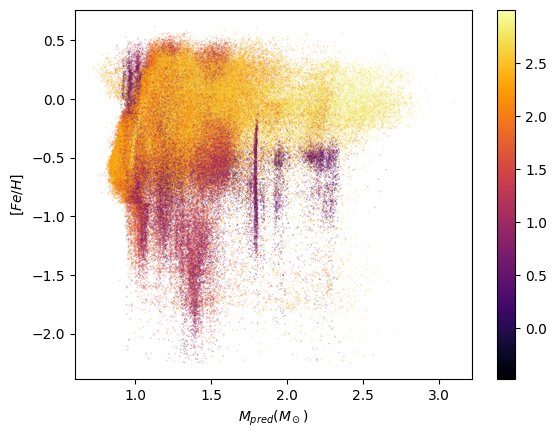

In [139]:
plt.scatter(red_giants_apogee.mass, red_giants_apogee.fe_h, marker='x', linewidths=0.1,
                      c=red_giants_apogee.logg, cmap=plt.cm.inferno, s=1)
plt.xlabel("$M_{pred} (M_\odot)$")
plt.ylabel("[$Fe/H$]")
plt.colorbar()

Now that we have gotten the data, we can begin to look at deep mixing present in each stars.

In [29]:
deep_mixing_measurement = pd.DataFrame(columns=["gradient", "avg_mass", "avg_fe_h"])

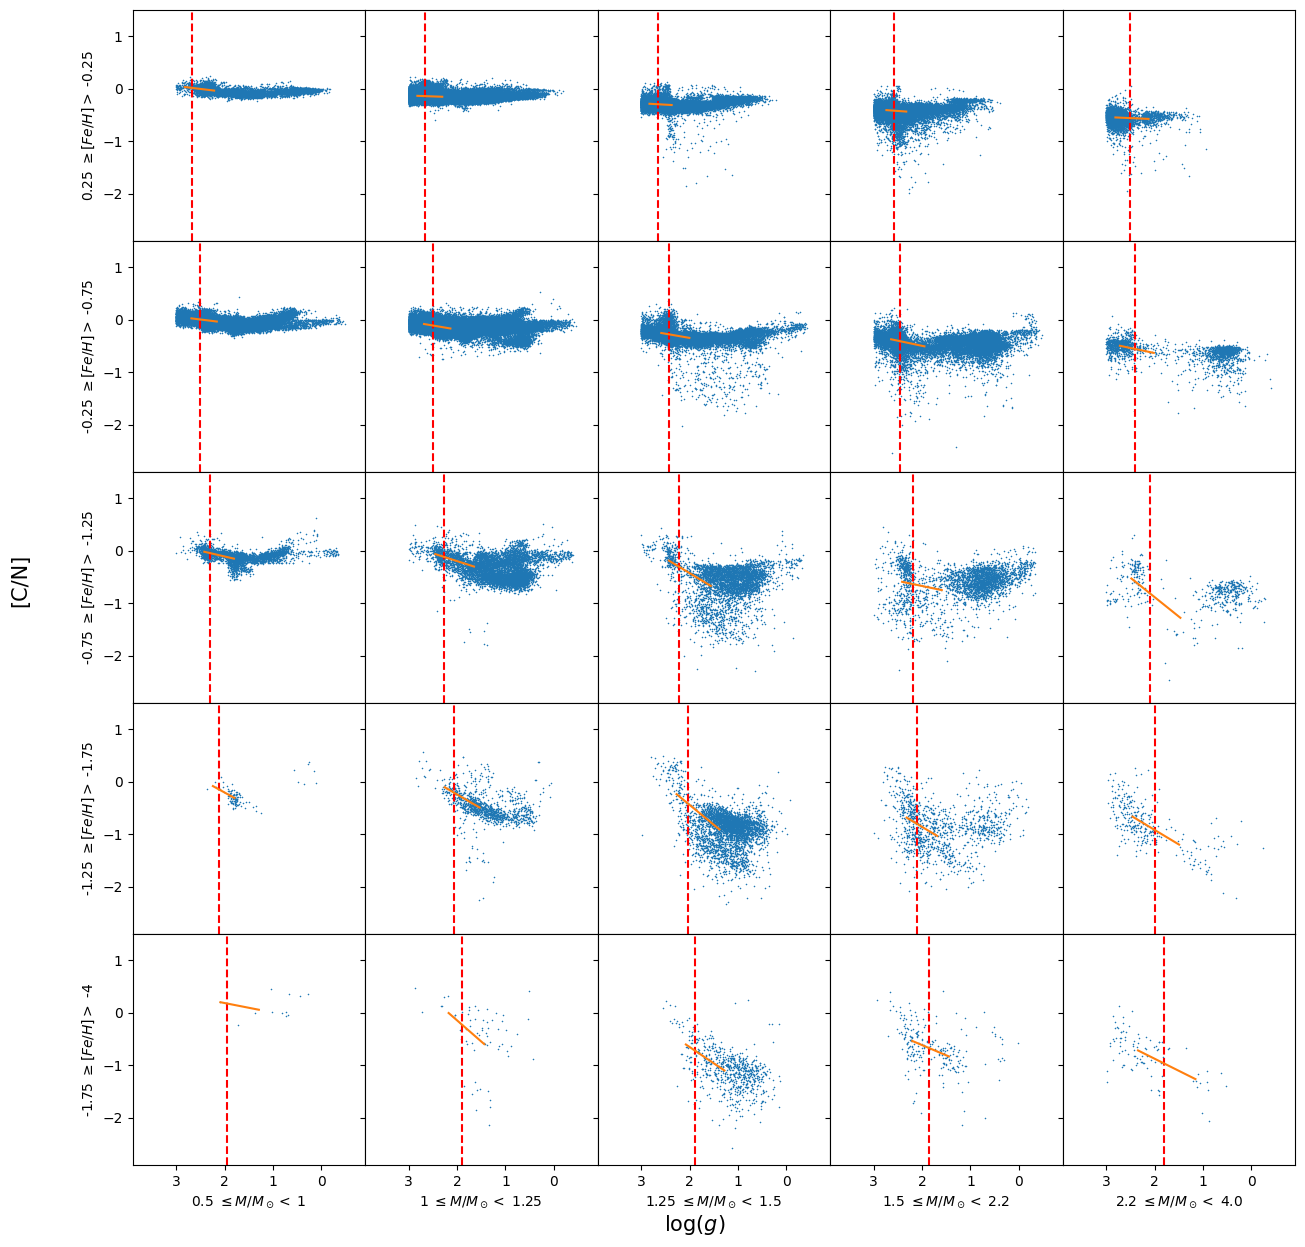

In [125]:
figure, axis = plt.subplots(
    nrows=5,
    ncols=5,
    figsize=(15, 15),
    sharex=True,
    sharey=True
)

figure.subplots_adjust(hspace=0)
figure.subplots_adjust(wspace=0)
figure.text(0.5, 0.07, "$\log(g)$", ha="center", va="center", fontsize=15)
figure.text(0.05, 0.5, "[C/N]", ha="center", va="center", rotation="vertical",fontsize=15)
plt.axis([3.9, -0.9, -2.9, 1.5])

index = 0
# Populate each part of the graph
for i in range(0, 5): # Iterate over metallicity
    for j in range(0, 5): # Iterate over mass
        bin = red_giants_apogee[
            (red_giants_apogee.mass >= mass_range[j]) & (red_giants_apogee.mass < mass_range[j + 1]) & (red_giants_apogee.fe_h <= fe_h_range[i]) & (red_giants_apogee.fe_h > fe_h_range[i + 1])
        ]

        # Labels
        axis[i, j].set_xlabel(f"{mass_range[j]} $\leq M/M_\odot <$ {mass_range[j+1]}")
        if (j == 0):
            axis[i, j].set_ylabel(f"{fe_h_range[i]} $\geq [Fe/H] >$ {fe_h_range[i+1]}")
        # Plot the data and where deep mixing should occur
        axis[i, j].plot(bin.logg, bin.c_n,"x", markersize=.5)
        axis[i, j].axvline(x=rgbbedge[i][j], color='r', linestyle='--')

        # Deep Mixing calculation logg [RGBBEdge - 0.1, RGBBEDGE) and [RGBBEDGE, RBBBEDGE + 0.1)
        after = bin.loc[bin.logg >= rgbbedge[i][j] - 1]
        after = after.loc[after.logg < rgbbedge[i][j]]
        b_logg = mean(after.logg)
        b_c_n = mean(after.c_n)


        before = bin.loc[bin.logg >= rgbbedge[i][j]]
        before = before.loc[before.logg < rgbbedge[i][j] + 1]
        a_logg = mean(before.logg)
        a_c_n = mean(before.c_n)

        x_values = [a_logg, b_logg]
        y_values = [a_c_n, b_c_n]
        axis[i, j].plot(x_values, y_values)

        all = pd.concat([after, before])
        avg_mass = mean(all.mass)
        avg_fe_h = mean(all.fe_h)

        gradient = -(a_c_n - b_c_n) / (a_logg - b_logg)
        deep_mixing_measurement.loc[index] = [gradient, avg_mass, avg_fe_h]
        index = index + 1

We make the gradient $\frac{d[C/N]}{d log(g)}$ for each bin.

- For each bin, we also calculated the average mass and metallicity.

 Now we determine the strength of each parameter

In [126]:
deep_mixing_measurement

,gradient,avg_mass,avg_fe_h
0,-0.112833,0.957002,-0.144630
1,-0.033410,1.123249,-0.025516
2,-0.051977,1.367164,-0.053315
3,-0.066628,1.736869,-0.016014
4,-0.040697,2.417910,-0.025555
5,-0.114316,0.947203,-0.469614
6,-0.156586,1.103579,-0.421374
7,-0.160203,1.345397,-0.398862
8,-0.195421,1.720489,-0.407735
9,-0.193597,2.335735,-0.367450


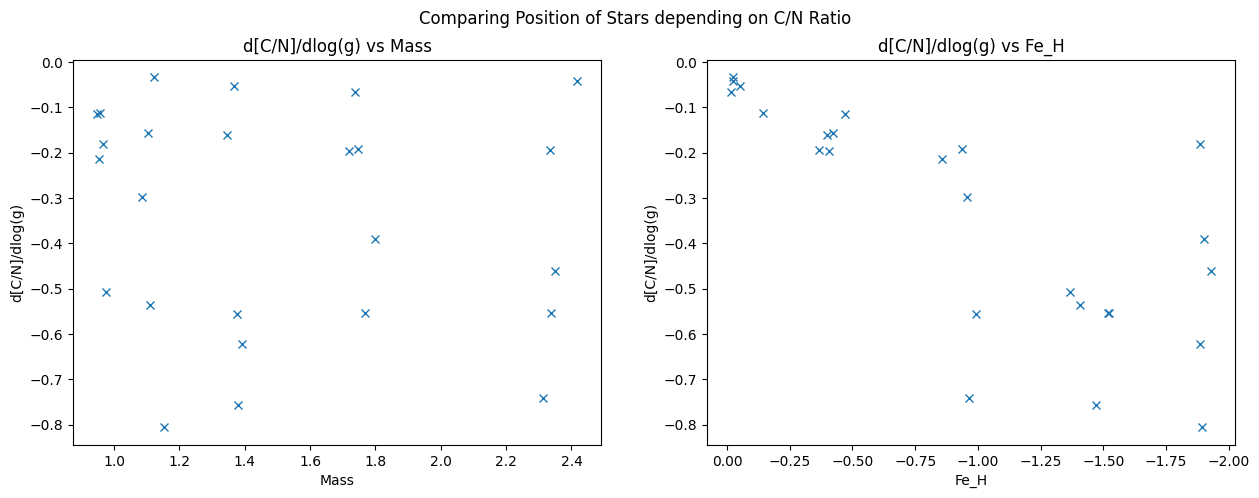

In [127]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

figure.suptitle("Comparing Position of Stars depending on C/N Ratio")
ax1.plot(deep_mixing_measurement.avg_mass, deep_mixing_measurement.gradient, 'x')
ax1.set_title("d[C/N]/dlog(g) vs Mass")
ax1.set_xlabel("Mass")
ax1.set_ylabel("d[C/N]/dlog(g)")

ax2.plot(deep_mixing_measurement.avg_fe_h, deep_mixing_measurement.gradient, 'x')
ax2.set_title("d[C/N]/dlog(g) vs Fe_H")
ax2.set_xlabel("Fe_H")
ax2.set_ylabel("d[C/N]/dlog(g)")
ax2.invert_xaxis()


Looking at the data, it is very clear that metallicity is a much better predictor of deep mixing as lower metallicity stars see a much sharper drop in Carbon relative to high carbon stars.

Mass seems to have a much more muted impact of the amount of deep mixing that occurs.

## Additional Research: Investigating the dip
Notice that for all graphs, we can observe that there is a main group where most of the stars resides.
However, for some, some stars seem to fall under the main grouping (since the scale is logarithmic, this means the ratio between carbon to nitrogen is lower than 10 times for some data points!)

For this low $\Big[\frac{C}{N}\Big]$ stars, one potential answer is they may be either a part of a globular cluster and thus start out with lower relative abundances or AGB (asymptotic giant branch) stars.


### Globular Clusters

Text(0.5, 1.0, '$[C/N]$ vs Surface Gravity')

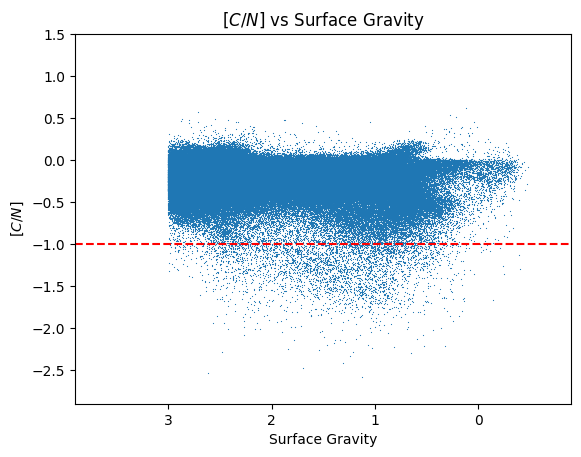

In [33]:
plt.plot(red_giants_apogee.logg, red_giants_apogee.c_n, 'x', markersize=0.2)
plt.axhline(-1, color='r', linestyle='--')
plt.axis([3.9, -0.9, -2.9, 1.5])
plt.xlabel("Surface Gravity")
plt.ylabel("$[C/N]$")
plt.title("$[C/N]$ vs Surface Gravity")

From the graph above, we can see that majority of stars have a carbon to nitrogen abundance greater than -1.

In [34]:
gc = red_giants_apogee.query("c_n < -1")

From here, to determine whether they are in fact from globular clusters, we can assess:
- Position
- Radial Velocity
- Proper Motion

We expect the data to form groups if they are in clusters.

/tmp/ipykernel_11788/2587646439.py:12: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=red_giants_apogee.vhelio_avg)


AttributeError: 'Series' object has no attribute 'get_array'

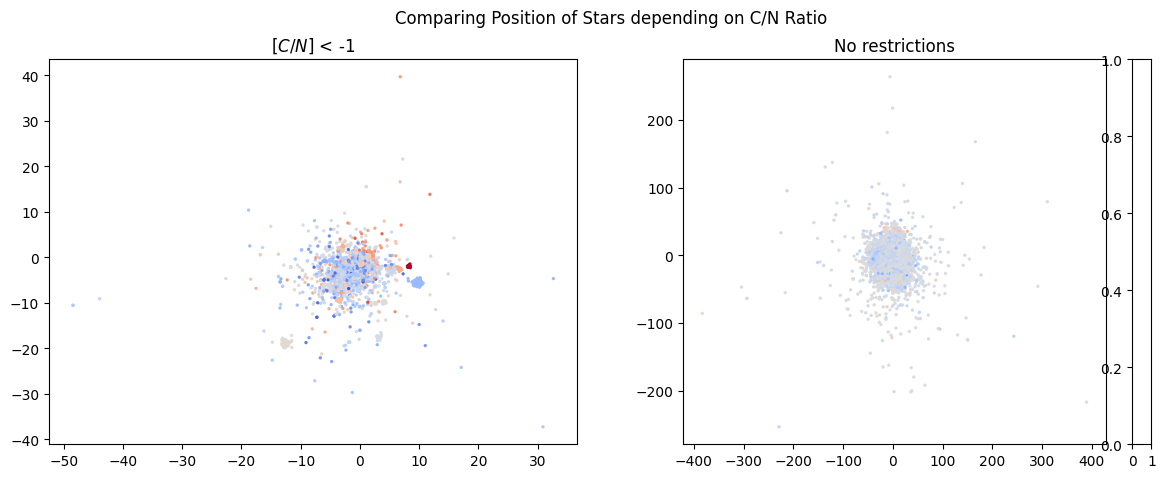

In [54]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

figure.suptitle("Comparing Position of Stars depending on C/N Ratio")
ax1.scatter(gc.gaiaedr3_pmra, gc.gaiaedr3_pmdec, marker='o', linewidth=0.1, c=gc.vhelio_avg, s=5, cmap=plt.cm.coolwarm)
# ax1.xlabel("PMRA")
# ax1.ylabel("PMDEC")
ax1.set_title("$[C/N]$ < -1")

ax2.set_title("No restrictions")
ax2.scatter(red_giants_apogee.gaiaedr3_pmra, red_giants_apogee.gaiaedr3_pmdec, marker='o', linewidth=0.1, c=red_giants_apogee.vhelio_avg, s=5, cmap=plt.cm.coolwarm)

plt.colorbar(mappable=red_giants_apogee.vhelio_avg,)

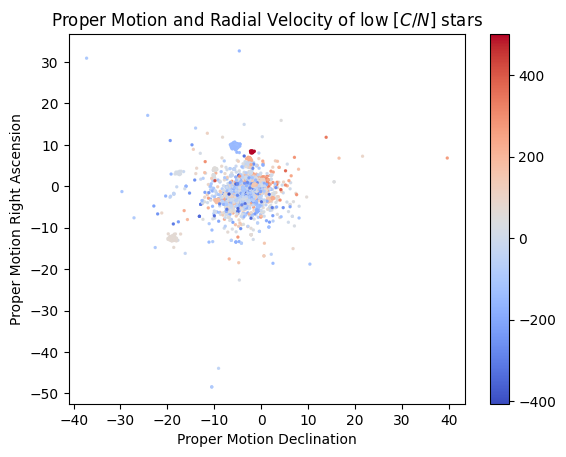

In [68]:
plt.scatter(gc.gaiaedr3_pmdec, gc.gaiaedr3_pmra, marker='o', linewidth=0.1, c=gc.vhelio_avg, s=5, cmap=plt.cm.coolwarm)

plt.xlabel("Proper Motion Declination")
plt.ylabel("Proper Motion Right Ascension")
plt.title("Proper Motion and Radial Velocity of low $[C/N]$ stars")
plt.colorbar()

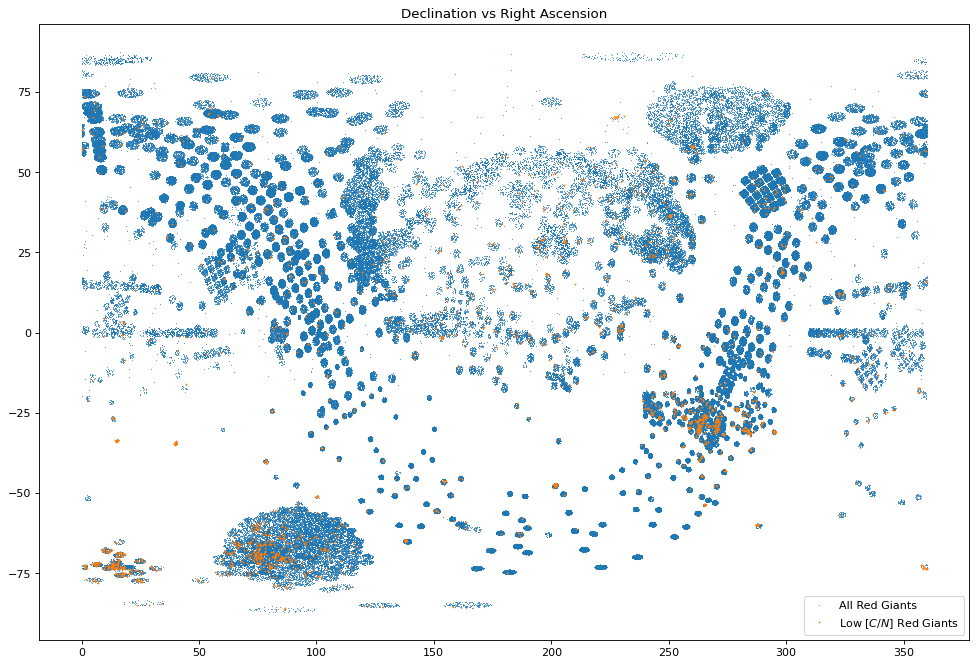

In [83]:
plt.figure(figsize=(15, 10), dpi=80)
plt.plot(red_giants_apogee.ra, red_giants_apogee.dec, 'x', markersize=.2)
plt.plot(gc.ra, gc.dec, 'x', markersize=1)

plt.title("Declination vs Right Ascension")
plt.legend(["All Red Giants", "Low $[C/N]$ Red Giants"])

This graph looks so pretty owo

(6000.0, 3000.0, 3.2, -0.5)

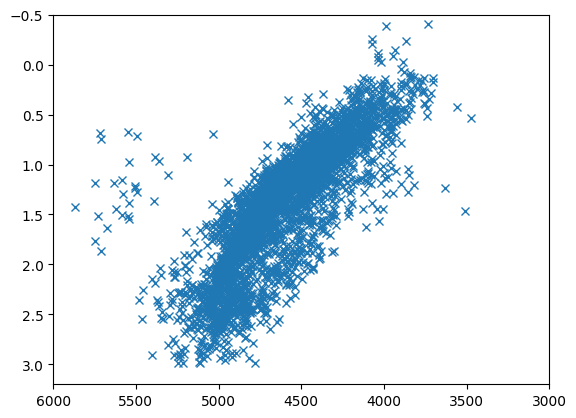

In [141]:
plt.plot(gc.teff, gc.logg, "x")
plt.axis([6000, 3000, 3.2, -0.5])

## Asymptotic Giant Branch Stars

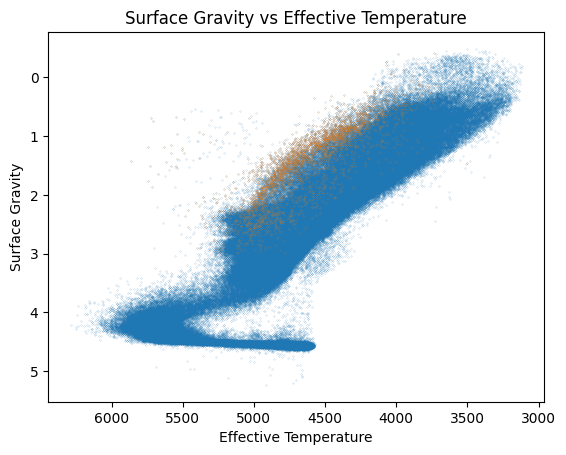

In [132]:
figure = plt.plot(
    apogee.teff,
    apogee.logg,
    '.',
    markersize=0.2,
)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Effective Temperature")
plt.ylabel("Surface Gravity")
plt.title("Surface Gravity vs Effective Temperature")

plt.plot(gc.teff, gc.logg, '.', markersize=0.2)